<a href="https://colab.research.google.com/github/fxnnxc/class-MachineLearning/blob/master/Assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment09 

Multi-label classification using neural networks

##  Codes

### Read file and split train and test data 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "/content/drive/My Drive/Classroom/Machine Learning (1) 2020-1/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images


def normalize(data):
    data_normalized = (data - min(data)) / (max(data) - min(data))
    return(data_normalized)

def distance(x, y):
    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1


In [0]:
# Install CuPy

#!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80

In [0]:
import cupy as cp

def one_hot(y):
  oneHotY = np.zeros((10, len(y)))
  for i in range(len(y)):
    oneHotY[y[i]][i] = 1
  return oneHotY


X_train = cp.asarray(list_image[:,:6000])
X_test  = cp.asarray(list_image[:,6000:])
y_train_index = cp.asarray(list_label[:6000])
y_test_index = cp.asarray(list_label[6000:])
y_train = cp.asarray(one_hot(list_label[:6000]))
y_test  = cp.asarray(one_hot(list_label[6000:]))

In [0]:
# Utilities [ LOSS, ACCURACY ]
def loss_acc(X, y,y_index):
  H = forward(X)
  v = cp.sum(-cp.multiply(y, cp.log(H)) - cp.multiply(1-y, cp.log(1-H)))
  
  w = cp.argmax(H, axis=0)
  w = cp.sum(cp.equal(w, y_index))
  return (v, w/H.shape[1]*100)


## Training

Loss Function : $J(\theta) = {1 \over M} \sum (l*log(h) - (1-l) log(1-h))$

How to update theta : $\theta_i = \theta_i - \alpha( \sum{(\sigma - Label)*x_i} )$



 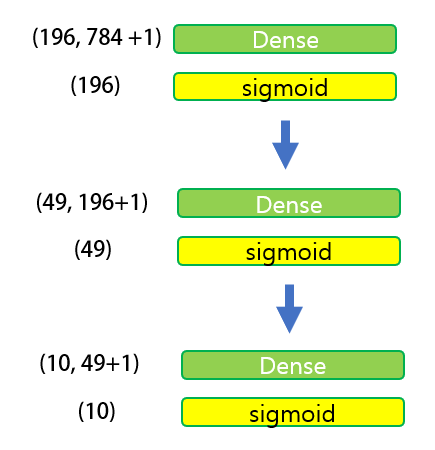



In [0]:
# Shapes
input_size  = 784 
layer1_size = 196 
layer2_size = 49 
output_size = 10

# Weights
layer1 = cp.random.normal(0,1,(layer1_size, input_size+1 ))   # With bias
layer2 = cp.random.normal(0,1,(layer2_size, layer1_size+1))  # With bias
outlay = cp.random.normal(0,1,(output_size, layer2_size+1))  # With bias

# stores
loss_train = []
loss_test  = []
acc_train  = []
acc_test   = []

# learing rate
lr =  0.001

In [0]:
# Functions

def sigmoid(x):  
  return 1/(1+cp.exp(-x))

def forward(x):  # To predict right, worng answer and to calculate loss and accuracy
    global outlay, layer1, layer2
    # Layer 1
    output = cp.concatenate((x, cp.ones((1, len(x[0])))), axis=0)
    output = layer1.dot(output) 
    output = sigmoid(output)

    # Layer 2
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)   
    output = layer2.dot(output)
    output = sigmoid(output)
    
    # Output layer
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)
    output = outlay.dot(output)
    output = sigmoid(output)

    return output

def train(x, y):
    global outlay, layer1, layer2, lr

    # Forward -----------------------------------------------------------------
    # Layer 1


    output = cp.concatenate((x, cp.ones((1, len(x[0])))), axis=0)
    value1 = output
    output = cp.dot(layer1, output)
    output = sigmoid(output)
    sigval1 = output

    # Layer 2
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)   
    value2 = output
    output = cp.dot(layer2, output)
    output = sigmoid(output)
    sigval2 = output

    
    # Output layer
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)
    value3 = output
    output = cp.dot(outlay, output)
    output = sigmoid(output)

    # Backward ----------------------------------------------------------------
    temp1 = cp.dot(output - y, value3.T)/6000
    outlay -= lr*temp1



    # layer2
    a = cp.multiply(sigval2, (1-sigval2))
    b = value2
    temp2 = cp.dot(a,b.T)/6000
    tt2 = cp.sum(temp1, axis=0)[:-1]
    tt2 = cp.broadcast_to(tt2,(197,49)).T
    back2 = cp.multiply(tt2 , temp2)
    layer2 -= lr*back2

    # layer1
    c = cp.multiply(sigval1, (1-sigval1))
    d = value1
    temp3 = cp.dot(c,d.T)/6000
    tt3 = cp.sum(back2, axis=0)[:-1]
    tt3 = cp.broadcast_to(tt3, (785,196)).T
    back3 = cp.multiply(tt3, temp3)
    layer1 -= lr*back3

    return 

In [0]:
# Training
COUNT = 1000000

for k in range(0, COUNT+1):
  train(X_train, y_train)

  a,b = loss_acc(X_train, y_train, y_train_index)
  c,d = loss_acc(X_test, y_test, y_test_index)
  loss_train.append(a)
  loss_test.append(c)
  acc_train.append(b)
  acc_test.append(d)


In [0]:
# Predict 10 right answer and 10 wrong answer
H = forward(X_test)
y = cp.argmax(H, axis=0)

right_index = [None]*10
right_label = [None]*10
wrong_index = [None]*10
wrong_label = [None]*10

right_count = 0
wrong_count = 0

i = 0
while right_count<10:             # Right prediction
    if y[i]== y_test_index[i]:
        right_index[right_count] = i+6000
        right_label[right_count] = int(y[i])
        right_count +=1
    i+=1

i=0  
while wrong_count<10:             # Wrong prediction
    if y[i] !=y_test_index[i]:
        wrong_index[wrong_count] = i+6000
        wrong_label[wrong_count] = int(y[i])
        wrong_count +=1
    i+=1

right_image =list_image[:,right_index]
wrong_image =list_image[:,wrong_index]

##  Result

###  Plot the loss curve

The training loss at every iteration of gradient descent



Text(0.5, 1.0, 'Loss Curve')

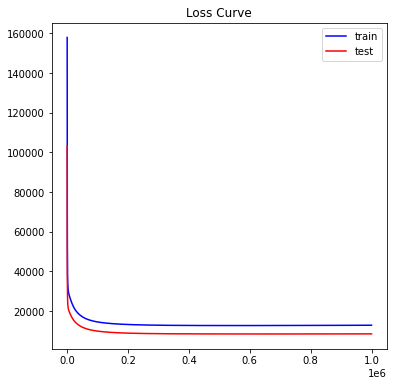

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(loss_train, color='b')
plt.plot(loss_test,  color='r')
plt.legend(['train', 'test'])
plt.title('Loss Curve')

### Plot the accuracy curve

The training accuracy (%) at every iteration of gradient descent 

Text(0.5, 1.0, 'Accuracy Curve')

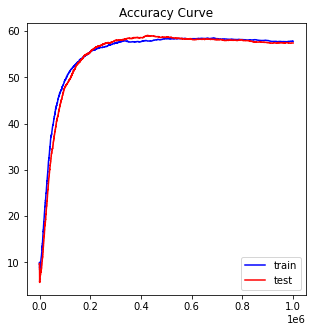

In [16]:
plt.figure(figsize=(5,5))
plt.plot(acc_train, color='b')
plt.plot(acc_test , color='r')
plt.legend(['train', 'test'])
plt.title('Accuracy Curve')

###  Plot the accuracy value

The final training accuracy (%) 

In [17]:
from termcolor import colored

print(colored(f"Final Training Accuracy Of Train Data : {float(acc_train[-1]):.1f}%", 'blue'))
print(colored(f"Final Training Accuracy Of Test  Data : {float(acc_test[-1]):.1f}%", 'red'))

Final Training Accuracy Of Train Data : 57.8%
Final Training Accuracy Of Test  Data : 57.5%


###  Plot the classification example

present 10 correctly classified testing images

present 10 misclassified testing images 

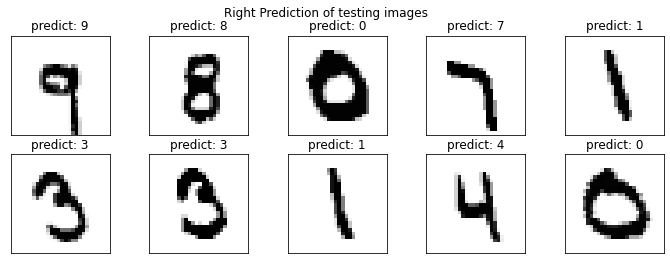

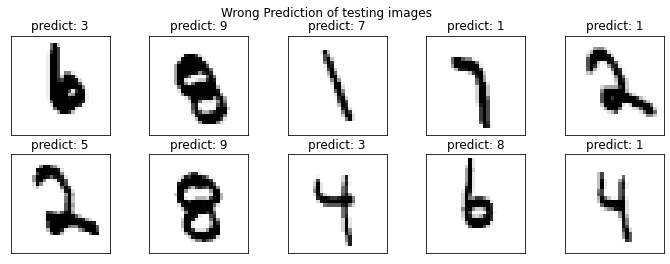

In [18]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Right Prediction of testing images')
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(f"predict: {right_label[i]}")
    v = right_image[:,i]
    plt.imshow(v.reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(12,4))
fig.suptitle('Wrong Prediction of testing images')
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(f"predict: {wrong_label[i]}")
    plt.imshow(wrong_image[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
